In [1]:
import csv,math
from IPython.display import display, HTML
import tabulate
import matplotlib.pyplot as plt

%matplotlib inline

# In this notebook we compare 2021 submitted groupoings as provided by NKH for California
# with optimized groupings done by Meals Count
# Comparison is Like-for-Like, as in only schools that were submitted to CEP will be grouped

# First, we load ADP data
sites = {}
for row in csv.DictReader(open("working/CA ADP Data 2.csv")):
    sites[row["Site_ID"]] = {
        "district_code":row["Sponsor_ID"],
        "school_code": row["Site_ID"],
        "district_name":row["Sponsor_Name"],
        "school_name":row["Site_Name"],
        "daily_breakfast_served":float(row["Breakfast_ADP_F"]) + float(row["Breakfast_ADP_R"]) + float(row["Breakfast_ADP_P"]),
        "daily_lunch_served":float(row["Lunch_ADP_F"]) + float(row["Lunch_ADP_R"]) + float(row["Lunch_ADP_P"]),
        "adp_enroll": row["Enrollment_Total"] and float(row["Enrollment_Total"]) or None
    }

len(sites)

9002

In [2]:
missing_adp_enroll = len([s for s in sites.values() if s['adp_enroll'] == None])
missing_adp_enroll,len(sites) - missing_adp_enroll

(289, 8713)

In [3]:
# Then Load Grouping Data and enrollment/ISP data
for row in csv.reader(open("working/CA_CEP_2021.csv")):
    if row[2] in sites and row[5]: # skip if no ISP
        site = sites[row[2]]
        site["total_enrolled"] = int(row[13].replace(",",""))
        site["total_eligible"] = int(float(row[5].replace("%",""))/100 * site["total_enrolled"])
        site["grouping"] = row[10] or row[12] or None
        if site["adp_enroll"]:
            # If we have enrollment matching the ADP data, use this to create an ADP% and apply to our grouping 
            # enrollment. Otherwise we are stuck with what we have
            site["daily_breakfast_served"] = site["daily_breakfast_served"]/site["adp_enroll"] * site["total_enrolled"]
            site["daily_lunch_served"] = site["daily_lunch_served"]/site["adp_enroll"] * site["total_enrolled"]

schools = [s for s in sites.values() if s.get("grouping",False)]
"%i of %i Grouped" % (len(schools),len(sites)),"%f %%" % (len(schools)/len(sites) * 100)

('3185 of 9002 Grouped', '35.381026 %')

Text(0, 0.5, 'Sites Per District')

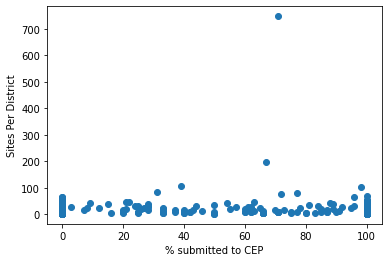

In [4]:
# chart % of sites per district submitted to CEP vs # of overall sites per district

overall_districts = {}
for site in sites.values():
    overall_districts.setdefault(site["district_code"],[])
    overall_districts[site["district_code"]].append(site)

fig,ax = plt.subplots()
ax.scatter(
    [int(len([s for s in d if s.get("grouping",False)])/len(d) * 100) for d in overall_districts.values()], # % submitted to CEP per district
    [len(d) for d in overall_districts.values()], # overall sites per district
)
ax.set_xlabel('% submitted to CEP')
ax.set_ylabel('Sites Per District')

Text(0, 0.5, 'ISP %')

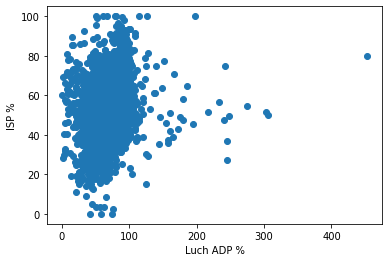

In [5]:
fig,ax = plt.subplots()
ax.scatter(
    [(s["daily_lunch_served"]/s["total_enrolled"] * 100) for s in schools], # Lunch ADP %
    [(s["total_eligible"]/s["total_enrolled"] * 100.0) for s in schools], # ISP
)
ax.set_xlabel('Luch ADP %')
ax.set_ylabel('ISP %')
#plt.hist([(s["daily_lunch_served"]/s["total_enrolled"] * 100) for s in schools], 20, label='Lunch ADP')
#plt.show()

In [6]:
upsidedown = [s for s in schools if s["total_enrolled"] <= s["daily_lunch_served"]]
"%i of %i schools have more lunches than enrolled" % (len(upsidedown),len(schools))

sum([(s["daily_lunch_served"]/s["total_enrolled"] * 100) for s in schools])/len(schools),sum([(s["daily_breakfast_served"]/s["total_enrolled"] * 100) for s in schools])/len(schools)

(73.12374789734832, 46.46360890861966)

In [7]:
upsidedown_mismatch = [s for s in schools if s["total_enrolled"] <= s["daily_lunch_served"] and s["adp_enroll"] == None]
"%i of %i schools have more lunches than enrolled and have mismatched enrollment data" % (len(upsidedown),len(schools))

'132 of 3185 schools have more lunches than enrolled and have mismatched enrollment data'

In [8]:
annual = lambda x: "${:,} / yr".format(int(x * 180))

In [9]:
# Build our CEP District for San Diego as a test case
from strategies.base import CEPSchool,CEPDistrict

districts = {}
for s in schools:
    school = CEPSchool(s)
    if s["district_code"] not in districts:
        districts[s["district_code"]] = CEPDistrict(s["district_name"],s["district_code"])
    districts[s["district_code"]].add_school(school)
districts = list(districts.values())
districts.sort(key=lambda d:len(d.schools))

len(districts),len(schools)

(254, 3185)

In [10]:
district = [d for d in districts if "San Diego" in d.name][0]
district.name,len(district.schools),district.code,district.overall_isp,district.total_enrolled

('San Diego Unified School District',
 133,
 '3768338',
 0.44208626655530364,
 67048)

In [11]:
# View San Diego school data

school_table = [('School','Total Enrolled','ISP%','Breakfast','Lunch','Orig Grouping','%Lunch ADP')] + \
            [ (
                s.name,
                s.total_enrolled,
                ('%0.2f%%' % (s.isp*100.0)),
                s.bfast_served,
                s.lunch_served, 
                sites.get(s.code).get("grouping"),
                '%0.2f%%' % (s.lunch_served/s.total_enrolled * 100),
            ) 
              for s in district.schools ]

display(HTML(tabulate.tabulate(school_table,tablefmt='html')))

School,Total Enrolled,ISP%,Breakfast,Lunch,Orig Grouping,%Lunch ADP
WALKER ELEMENTARY,434,50.46%,424,390,G1,89.86%
Madison High,932,37.77%,309,308,G2,33.05%
ANGIER ELEMENTARY,419,22.43%,70,220,G2,52.51%
King-Chavez Academy of Excellence,277,48.74%,254,248,G3,89.53%
CROWN POINT ELEMENTARY,273,28.21%,77,151,G2,55.31%
EDISON ELEMENTARY,366,69.40%,385,383,G1,104.64%
EMERSON/BANDINI ELEMENTARY,411,72.02%,261,241,G2,58.64%
HORTON ELEMENTARY,389,80.46%,391,382,G1,98.20%
OCEAN BEACH ELEMENTARY,401,29.93%,69,251,G2,62.59%
McGill School of Success,142,42.96%,134,112,G3,78.87%


In [12]:
# Build two strategies: Custom Group to represent what was submitted, and NYCMODA for optimal
from strategies.naive import CustomGroupsCEPStrategy

# What was submitted to USDA in 2021
orig_strategy = CustomGroupsCEPStrategy()
orig_strategy.set_groups([('%s-%s'%(s["district_code"],s["grouping"]),s["school_code"]) for s in schools])



In [13]:
# Calculate reimbursement for groupings submitted to USDA
submitted_reimbursements = {}
submitted_group_counts = {}

for d in districts:
    orig_strategy.create_groups(d)
    submitted_reimbursements[d.code] = orig_strategy.reimbursement
    submitted_group_counts[d.code] = len([g for g in orig_strategy.groups if len(g.schools)])
submitted_reimbursements

{'1263024': 416.94,
 '5472181': 1465.11,
 '2075580': 195.19,
 'GD42': 374.51,
 '3073643': 640.2,
 'GD158': 1628.39,
 '4369484': 1409.0,
 'GD166': 5145.14,
 '0961952': 1192.26,
 'GD49': 97.74,
 'GD162': 1853.24,
 'GD155': 1142.53,
 '1563784': 578.69,
 '1663925': 271.26,
 '3510355': 9.09,
 '3310330': 469.79,
 '0461382': 336.0,
 '3166894': 82.7,
 '0261333': 219.06,
 '1563438': 4877.55,
 '5472041': 3514.2299999999996,
 '1262679': 1008.13,
 '5375028': 900.81,
 '5471803': 1141.74,
 '4068833': 808.0,
 '4570011': 1103.06,
 '1363081': 185.94,
 '3773569': 2720.51,
 '1965078': 3121.04,
 'GD43': 1082.61,
 'GD214': 2194.67,
 'GD264': 1752.81,
 'GD144': 2189.95,
 '2365540': 1627.22,
 '1964790': 612.52,
 '3066472': 3366.63,
 '4570136': 244.35,
 '1563859': 3822.89,
 'GD196': 1586.78,
 '3367207': 4923.52,
 '1162653': 0,
 '3367231': 5620.3099999999995,
 'GD59': 0,
 '5071050': 1813.77,
 '1062281': 1639.49,
 '4970706': 366.88,
 '2866241': 766.93,
 'GD420': 1896.41,
 '2465821': 3376.35,
 '5271639': 3447.79

In [14]:
import ipywidgets as widgets
from IPython.display import display
from cep_estimatory import add_strategies
import multiprocessing
import time

t0 = time.time()

# SD Only
to_eval = [d for d in districts if d == district] # if len(d.schools) < 500]

cur = widgets.Label("")
out = widgets.HTML("")
f = widgets.IntProgress(min=0, max=sum([len(d.schools) for d in to_eval]))
x = widgets.VBox([cur,f,out])
display(x)

from lambda_function import lambda_handler

district_map = dict([(d.code,d) for d in to_eval])
STRATEGIES = [
    "Pairs",
    "OneToOne",
    "Exhaustive",
    "OneGroup",
    "Spread",
    "Binning",
    "NYCMODA?fresh_starts=50&iterations=1000&ngroups=10",
    "NYCMODA?fresh_starts=50&iterations=1000&ngroups=10&evaluate_by=schools",
    "GreedyLP"]

def processor(district):
    add_strategies(district,STRATEGIES)
    district.run_strategies()
    district.evaluate_strategies()
    return {
        "code":district.code,
        "reimb":district.best_strategy.reimbursement,
        "best":district.best_strategy.name,
        "groupings": [g.as_dict() for g in district.best_strategy.groups]
    }

total_change = 0

PROCESSES = multiprocessing.cpu_count() - 1
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(processor, (d,)) for d in to_eval]
    for r in results:
        result = r.get()
        _d = district_map[result["code"]]
        f.value += len(_d.schools)
        change = result["reimb"] - submitted_reimbursements[_d.code]
        if change != 0:
            out.value += "%s (%i schools) MC: %s - %0.0f => %0.0f (%0.0f)<br>" % (
                _d.name,
                len(_d.schools),
                result["best"],
                submitted_reimbursements[_d.code],
                result["reimb"],
                change
            )
        total_change += change

total_time = time.time() - t0

In [15]:
"${:,} / yr".format(int(total_change * 180))

'$11,398,210 / yr'

In [16]:
changes = []
def m(x): return "${:,}".format(int(x))

result_data = [r.get() for r in results] 

for r in result_data:
    _d = district_map[r["code"]]
    change = r["reimb"] - submitted_reimbursements[_d.code]
    if submitted_reimbursements[_d.code] == 0:
        pchange = 1.0
    else:
        pchange = change / submitted_reimbursements[_d.code]
    changes.append( (_d,change,pchange,r))
changes.sort(key=lambda x:x[1],reverse=True)
print("Top 20 Biggest Changes of %i districts" % len(to_eval))
for d in changes[:20]:
    print(
        d[0].name,
        " (%i schools submitted)" % len(d[0].schools),
        annual(submitted_reimbursements[d[0].code]),"=>",annual(d[3]["reimb"]),
        "+%s / yr" % annual(d[1])," +%0.1f%%" % (d[2]*100)
    )

Top 20 Biggest Changes of 1 districts
San Diego Unified School District  (133 schools submitted) $20,241,095 / yr => $31,639,305 / yr +$11,398,210 / yr / yr  +56.3%


In [17]:
len(district_map),sum([len(d.schools) for d in district_map.values()])

(1, 133)

In [18]:
optimized_reimbursements = [r.get()["reimb"] for r in results]
submitted = [r[1] for r in submitted_reimbursements.items()]

len(submitted),len(optimized_reimbursements)


(254, 1)

In [19]:
annual(sum(submitted_reimbursements.values())),annual(sum(optimized_reimbursements))

('$928,665,360 / yr', '$31,639,305 / yr')

In [20]:
result_data.sort(key=lambda r: r["reimb"],reverse=True)
result_table = [ ('District','District Code','Schools','Submitted Schools','Submitted','Optimized','%increase','Algo') ] + [
    (  district_map[r['code']].name,
       r['code'],
       len(overall_districts[r['code']]),
       "%i%%" % int(len(district_map[r['code']].schools)/len(overall_districts[r['code']]) * 100), 
       annual(submitted_reimbursements[r['code']]),
       annual(r['reimb']),
       r['reimb'] and "%i%%" % int((1 - submitted_reimbursements[r['code']]/r['reimb']) * 100) or '',
       r['best']
    )
    for r in result_data
]

display(HTML(tabulate.tabulate(result_table,tablefmt='html')))

District,District Code,Schools,Submitted Schools,Submitted,Optimized,%increase,Algo
San Diego Unified School District,3768338,196,67%,"$20,241,095 / yr","$31,639,305 / yr",36%,NYCMODA?fresh_starts=50&iterations=1000&ngroups=10


In [21]:
annual((sum(optimized_reimbursements) - sum(submitted_reimbursements.values())))

'$-897,026,054 / yr'

In [22]:
submitted_reimbursements["4770466"],"%0.2f" % (total_time/60)

(0, '3.65')

<AxesSubplot:>

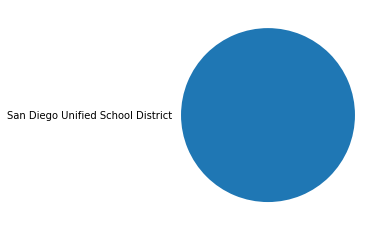

In [23]:
fig,ax = plt.subplots()
ax.pie(
    [c[1] for c in changes], labels= [(i<8 and c[0].name or '') for i,c in enumerate(changes)]
)
ax

Text(0, 0.5, 'number of schools')

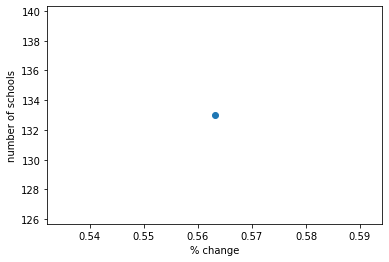

In [24]:
fig,ax = plt.subplots()

normal_changes = [ c for c in changes if c[2] < 1.0 ]
ax.scatter(
    [c[2] for c in normal_changes ],
    [len(c[0].schools) for c in normal_changes ],
)
ax.set_xlabel('% change')
ax.set_ylabel('number of schools')

KeyError: '1263024'

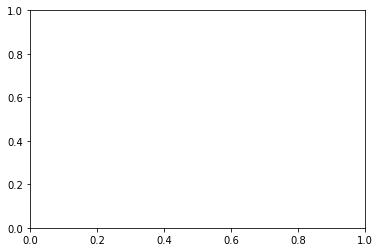

In [25]:
fig,ax = plt.subplots()


ax.scatter(
    [cnt for cnt in submitted_group_counts.values() ],
    [len(district_map[g].schools) for g in submitted_group_counts ],
)
ax.set_xlabel('number of groups')
ax.set_ylabel('number of schools')

Text(0, 0.5, 'number of schools')

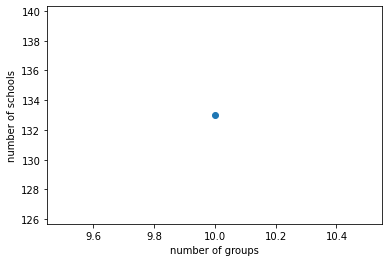

In [26]:
fig,ax = plt.subplots()


ax.scatter(
    [len(r['groupings']) for r in result_data ],
    [len(district_map[r['code']].schools) for r in result_data ],
)
ax.set_xlabel('number of groups')
ax.set_ylabel('number of schools')

In [27]:
district

In [28]:
result_data[0]

{'code': '3768338',
 'reimb': 175773.91999999998,
 'best': 'NYCMODA?fresh_starts=50&iterations=1000&ngroups=10',
 'groupings': [{'name': 'Group 0',
   'school_codes': ['37683386059588',
    '37683380107177',
    '37683383730116',
    '37683380114025',
    '37683380118851',
    '37683386039598',
    '37683386093256',
    '37683386039713',
    '37683386039796',
    '37683386109599',
    '37683386061980',
    '37683386106173',
    '37683383734431',
    '37683380116939',
    '37683386039309',
    '37683380111906',
    '37683386096051'],
   'school_reimbursements': [('37683380111906', 859.04),
    ('37683386039309', 436.53),
    ('37683386039598', 530.78),
    ('37683380118851', 443.5),
    ('37683386061980', 1275.63),
    ('37683386059588', 1431.93),
    ('37683380107177', 1960.99),
    ('37683380116939', 662.59),
    ('37683386039713', 520.44),
    ('37683386096051', 1175.15),
    ('37683386109599', 782.48),
    ('37683383730116', 303.34),
    ('37683380114025', 2161.86),
    ('3768338603

In [29]:
orig_strategy.create_groups(district)

In [30]:
[(g,len(g.schools)) for g in orig_strategy.groups if g.schools]

[(<strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 3768338-G1 ISP=54% ENROLLED=24180 FREE_RATE=86.83%,
  53),
 (<strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 3768338-G2 ISP=37% ENROLLED=34161 FREE_RATE=0.00%,
  65),
 (<strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 3768338-G3 ISP=49% ENROLLED=6364 FREE_RATE=78.27%,
  13),
 (<strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 3768338-G4 ISP=39% ENROLLED=2343 FREE_RATE=0.00%,
  2)]

In [31]:
orig_strategy.reimbursement

112450.53000000001

In [32]:
(result_data[0]['reimb'] - orig_strategy.reimbursement) * 167

10575006.129999995

In [36]:
from strategies.base import CEPGroup
groups = []
i=0
for g in result_data[0]["groupings"]:
    group = CEPGroup(district,g["name"],schools=[s for s in district.schools if s.code in g["school_codes"]])
    groups.append(group)
    i+=1

groups

[<strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 0 ISP=40% ENROLLED=10048 FREE_RATE=64.08%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 1 ISP=40% ENROLLED=11251 FREE_RATE=64.00%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 2 ISP=62% ENROLLED=3585 FREE_RATE=99.66%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 3 ISP=61% ENROLLED=7693 FREE_RATE=97.86%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 4 ISP=40% ENROLLED=4045 FREE_RATE=64.00%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 5 ISP=22% ENROLLED=6178 FREE_RATE=0.00%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 6 ISP=50% ENROLLED=4547 FREE_RATE=80.05%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 7 ISP=40% ENROLLED=7697 FREE_RATE=64.32%,
 <strategies.base.CEPDistrict object at 0x7f16b421cfd0> / Group 8 ISP=62% ENROLLED=4619 FREE_RATE=99.79%,
 <strategies.base.CEPDistrict object at 0x7f1

In [40]:
[(s.name,s.isp) for s in [g for g in groups if g.est_reimbursement() == 0][0].schools]

[('Standley Middle', 0.2078),
 ('San Diego Metro Career and Tech', 0.2993),
 ('MIRA MESA HIGH', 0.2135),
 ('De Portola Middle', 0.1649),
 ('San Diego SCPA', 0.2688),
 ('PERSHING MIDDLE', 0.1933)]